In [30]:
import numpy as np 
from math import *
import random
import pandas as pd 
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from sklearn.metrics import mean_squared_error
import datetime

from sklearn.neighbors import NearestNeighbors

%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

import matplotlib
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 100

import warnings
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
warnings.filterwarnings('ignore')

### Initial Variables


In [31]:
########################################################
# Define variables which we will use later in the script
########################################################

# Number of nearest neighbours
nn=40

###################################
# Columns of interest for later use
###################################


parse_date_cols = ['dt_prediction_date', 'dt_target_date', 'dt_flight_date']

pax_list=["num_pax_000_014_mins_before_sdt","num_pax_015_029_mins_before_sdt",\
          "num_pax_030_044_mins_before_sdt","num_pax_045_059_mins_before_sdt",\
          "num_pax_060_074_mins_before_sdt","num_pax_075_089_mins_before_sdt",\
          "num_pax_090_104_mins_before_sdt","num_pax_105_119_mins_before_sdt",\
          "num_pax_120_134_mins_before_sdt","num_pax_135_149_mins_before_sdt",\
          "num_pax_150_164_mins_before_sdt","num_pax_165_179_mins_before_sdt",\
          "num_pax_180_194_mins_before_sdt","num_pax_195_209_mins_before_sdt",\
          "num_pax_210_224_mins_before_sdt","num_pax_225_239_mins_before_sdt",\
          "num_pax_240plus_mins_before_sdt"]

period=np.array([12,52,7,24])

                     # "cat_sdt_hour","cat_i_airport",\
                     # "cat_i_city","cat_destination_group_id","cat_longhaul_ind",\
                     # "cat_flight_class_type_id",\
            
            
cat_list=["cat_destination_group_id"]    
    
ord_list=["ord_leisure","ord_irish_residents","ord_trip_duration",\
          "ord_female","ord_party_size","ord_bag_checkin","ord_arrive_by_car"]

interesting_cols=["num_flight_month","num_flight_weekofyear",\
                  "num_flight_dayofweek",\
                  "ord_leisure","ord_irish_residents","ord_trip_duration",\
                  "ord_female","ord_party_size","ord_bag_checkin","ord_arrive_by_car"]


cols=["id"]+pax_list

In [34]:
df_train = pd.read_csv("./train.csv", parse_dates = parse_date_cols)

In [35]:
print(df_train.head(1))

   id dt_prediction_date dt_target_date s_model_type cat_case_type  \
0   1         2013-01-01     2014-01-01     52_weeks        Target   

   cat_i_flightno dt_flight_date  num_flight_year  num_flight_month  \
0           11075     2014-01-01             2014                 1   

   num_flight_weekofyear               ...                 \
0                      1               ...                  

   num_pax_105_119_mins_before_sdt  num_pax_120_134_mins_before_sdt  \
0                               12                               12   

   num_pax_135_149_mins_before_sdt  num_pax_150_164_mins_before_sdt  \
0                                0                                0   

   num_pax_165_179_mins_before_sdt  num_pax_180_194_mins_before_sdt  \
0                                0                                0   

   num_pax_195_209_mins_before_sdt  num_pax_210_224_mins_before_sdt  \
0                                0                                0   

   num_pax_225_239_mi

### Function to Normalise Data

In [32]:
def normalise_data(df):
    # Normalise temporal data to sin(pi*t/(L+1)) to ensure correct periodicity
    # Need to figure these out properly...
    df['num_flight_month']=np.sin(np.pi*df['num_flight_month']/13)
    df['num_flight_weekofyear']=np.sin(np.pi*df['num_flight_weekofyear']/53)
    df['num_flight_dayofweek']=np.sin(np.pi*df['num_flight_dayofweek']/8)
    df['cat_sdt_hour']=np.sin(np.pi*df['cat_sdt_hour']/25)

    # Normalise Ordinal data from 0 - 1
    df['ord_leisure']=df['ord_leisure']/5.0
    df['ord_irish_residents']=df['ord_irish_residents']/5.0
    df['ord_trip_duration']=df['ord_trip_duration']/5.0
    df['ord_female']=df['ord_female']/5.0
    df['ord_party_size']=df['ord_party_size']/5.0
    df['ord_bag_checkin']=df['ord_bag_checkin']/5.0
    df['ord_arrive_by_car']=df['ord_arrive_by_car']/5.0

    return df


### Function to Calculate Score of Model

In [33]:
def calculate_score(df_target_cases, df_predictions):
    '''Root-mean-squared error is the chosen error metric. This function calculates and returns the root-mean-squared error'''
    f_rmse = np.sqrt(mean_squared_error(df_target_cases, df_predictions))
    return f_rmse

### Read, Normalise and Extract Test/Train Data sets

In [22]:
###################################
# Read in csv file and parse dates.
###################################

# Training data
df_train = pd.read_csv("./train.csv", parse_dates = parse_date_cols)

# Test data
df_test = pd.read_csv("./test.csv", parse_dates = parse_date_cols)


###################################
# Normalise Data sets
###################################

df_train=normalise_data(df_train)
df_test=normalise_data(df_test)

###################################
# Extract Test/Training Data
###################################

# Data to initially be trained against
df_tr_target=df_train[df_train['cat_case_type']=='Target']

# Data to be used for training
df_tr_expl=df_train[df_train['cat_case_type']=='Expl']

# Data to eventually be predicted
df_test_target=df_test[df_test['cat_case_type']=='Target']

# Data to be used in prediction
df_test_expl=df_test[df_test['cat_case_type']=='Target']

In [85]:
df_tr_target_sample=df_tr_target.sample(n=500)
print(df_tr_target_sample.shape)

(500, 46)


### Module to compute K-Nearest Neighbours on Target Data

In [133]:
# WARNING: Takes ~30 mins to train
def test_knn(nn,df):
    #print("Start Time:",datetime.datetime.now().time())

    # Model solutions dataset
    df_model=[]

    # Loop over all the Target dates
    for test_index, test_row in df.iterrows(): 

    
        # Filter for training_flight_dates before target_prediction_date
        X=df_train[(df_tr_expl['s_model_type']==test_row['s_model_type'])&\
             (df_train['dt_flight_date']<test_row['dt_prediction_date'])]
    
        # Select only the columns of interest
        X=X[interesting_cols]
    
        # Compute Neareset Neighbours for this flight in historical data
        nbrs = NearestNeighbors(n_neighbors=nn, algorithm='auto').fit(X)
        distances, indices = nbrs.kneighbors(test_row[interesting_cols])

        # Introduce weighting to the model based on distance in feature-space
        w=np.exp(-distances)
        w=w/sum(sum(w))
    
        # Compute the pax arrival times based on weighted average of similar flights
        model=np.average(df_train.iloc[indices[0]][pax_list],axis=0,weights=w[0])
    
        df_model.append([test_row['id']]+model.tolist())

    # Convert model solution to DataFrame and write to file
    df_model=pd.DataFrame(df_model, columns=cols).set_index('id')
    df_model.to_csv("glenn_test.csv")
    #print("End Time:",datetime.datetime.now().time())

    return df_model




### Calculate Score against Number of Nearest Neighbours

In [134]:
for N in range(30,70,20):
    #print(N)
    #solution=test_knn(N,df_tr_target_sample)
    #print(N,calculate_score(df_tr_target_sample[pax_list].fillna(0),solution))

SyntaxError: unexpected EOF while parsing (<ipython-input-134-36212a7dcead>, line 4)

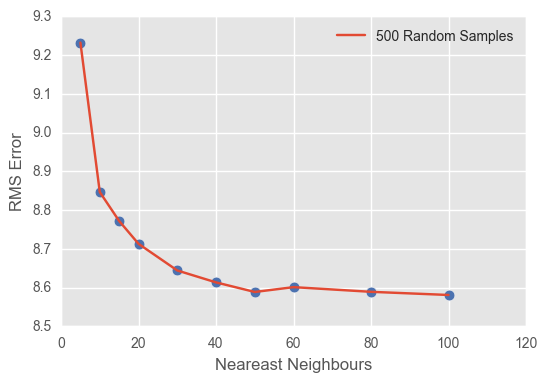

In [132]:
nntest=[5,10,15,20,30,40,50,60,80,100]
nnerror=[9.23190178068,8.84629697828,8.77161623894,\
         8.71266294321,8.64395002671,8.61318862677,\
         8.5884551726,8.60094136043,\
         8.58886932675,8.58070780619]

plt.scatter(nntest,nnerror,s=60)
line1=plt.plot(nntest,nnerror,label='500 Random Samples')
plt.xlabel('Neareast Neighbours')
plt.ylabel('RMS Error')
plt.legend(handles=line1)
plt.savefig("knn_convergence.png",bbox_inches='tight')

###  Run Full KNN Model

In [136]:
best_NN=40
df_model=test_knn(best_NN,df_tr_target)

In [138]:
print(calculate_score(df_tr_target[pax_list].fillna(0),df_model))

8.67477030602


### Test Random Target Flight

Flight ID:		 5244
Flight no:		 602
Prediction Date:	 2014-09-07 00:00:00
Target Date:		 2014-09-08 00:00:00
Model Type:		 01_day

RMS Error =  8.08900825887


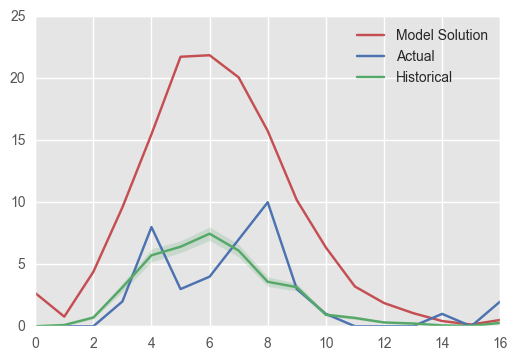

In [166]:
# Choose random flight from training data
r=random.randint(df_tr_target['id'].min(),df_tr_target['id'].max())
flight=df_tr_target.iloc[r]

# Basic Info about Flight
print ("Flight ID:\t\t",flight['id'])
print ("Flight no:\t\t",flight['cat_i_flightno'])
print ("Prediction Date:\t",flight['dt_prediction_date'])
print ("Target Date:\t\t",flight['dt_target_date'])
print ("Model Type:\t\t",flight['s_model_type'])


# Error compared to Actual Flight
model=df_model.iloc[r]

stderr=sum(((model.values-flight[pax_list].values)**2)/17)**0.5
print("\nRMS Error = ",stderr)

df_historical=df_tr_expl[(df_tr_expl['cat_i_flightno']==flight['cat_i_flightno']) &\
                     (df_tr_expl['s_model_type']==flight['s_model_type'])&\
                     (df_tr_expl['dt_flight_date']<flight['dt_prediction_date'])]

if df_historical[pax_list].size<=17: 
    print ("\nNo Historical Data Available")
    
else:
    
    historical=df_historical[pax_list].as_matrix()
    

    # Plot Model Prediction
    ax=sns.tsplot(data=model,color='r',legend=True,condition="Model Solution")
    # Actual Solution
    ax=sns.tsplot(data=flight[pax_list],color='b',legend=True,condition="Actual")
    # Historical Data
    ax=sns.tsplot(data=historical,color="g",legend=True,condition="Historical")

    ax.figure.savefig(str(flight['id'])+'_'+str(flight['s_model_type'])+'.png',bbox_inches='tight')
